# SIT215 Artificial and Computational Intelligence
## Project: Investigating Reinforcement Learning
### Bradley Stone 211333197

## 1. Import Dependencies

In [136]:
# Import dependencies
import gym
import math
import numpy as np
import random as rand
import seaborn as sns
import pandas as pd

from matplotlib.ticker import ScalarFormatter
from sklearn.preprocessing import KBinsDiscretizer

## 2. Defining Functions
### 2.1. Generic Functions

In [2]:
# Generic random policy function for any enviornment
def attemptRandomPolicy(env, iterations):

    # Create empty list to store results
    steps = []

    # Train agent over x iterations
    for i in range(1, iterations + 1):
        # Reset to the base state after every episode
        state = env.reset()

        # Initialise/reset variables
        total_steps = 0
        done = False

        # Main episode loop
        while not done:
            # Count for new step in episode
            total_steps += 1

            # Sample a random action from the sample space
            action = env.action_space.sample()

            # Execute random action
            state, reward, done, info = env.step(action)

        # Add total steps for episode to steps list
        steps.append(total_steps)
    
    # Return steps data
    return steps

In [3]:
# Function that returns a decaying alpha value
def decayingAlpha(i, decay, minAlpha=0.01):
    return max(minAlpha, min(1., 1. - math.log10((i + 1) / decay)))

In [4]:
# Function that returns a epsilon alpha value
def decayingEpsilon(i, decay, minEpsilon=0.1):
    return max(minEpsilon, min(1., 1. - math.log10((i + 1) / decay)))

In [5]:
# Function that determines the learned value by summing the current reward and discounted next qvalue
def getLearnedValue(gamma, actions, reward):
    nextQVal = np.max(actions)
    return reward + gamma * nextQVal

### 2.2. Taxi Problem Functions

In [6]:
# Define Taxi Q-learning training function that returns list of results
def trainTaxiQLearning(env, iterations, decayRate, gamma):

    # Create empty list to store results
    steps = []

    # Initialise the q-table
    q_table = np.zeros((env.observation_space.n, env.action_space.n))

    # Train agent over x iterations
    for i in range(1, iterations + 1):
        # Reset to the base state after every episode
        current_state = env.reset()

        # Initialise/reset variables
        total_steps = 0
        done = False

        # Main episode loop
        while not done:
            # Count for new step in episode
            total_steps += 1

            # Exploit next action using q-table
            action = np.argmax(q_table[current_state])

            # Use epsilon value to prompt for random exploration (sample from action space)
            if rand.uniform(0, 1) < decayingEpsilon(i, decayRate):
                action = env.action_space.sample()

            # Execute action and record results in variables
            next_state, reward, done, info = env.step(action)

            # Capture q-value for previous state and recent action
            current_qvalue = q_table[current_state][action]

            # Retrieve future q-value based on new state
            learnedValue = getLearnedValue(gamma, q_table[next_state], reward)

            # Current alpha
            alpha = decayingAlpha(i, decayRate)

            # Calculate new q-value for previous state and store in q-table
            new_qvalue = (1 - alpha) * current_qvalue + alpha * learnedValue
            q_table[current_state][action] = new_qvalue

            # Set new state to previous state variable
            current_state = next_state

        steps.append(total_steps)
    
    # Return
    return steps


### 2.3. CartPole Problem Functions

In [7]:
def discreteBox(env, buckets, state):
    upperBounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
    lowerBounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]

    discreteList = KBinsDiscretizer(n_bins=buckets, encode='ordinal', strategy='uniform')
    discreteList.fit([lowerBounds, upperBounds])
    return tuple(map(int, discreteList.transform([[state[0], state[1], state[2], state[3]]])[0]))

In [8]:
# Define CartPole Q-learning training function that returns list of results
def trainCartQLearning(env, iterations, buckets, decayRate, gamma):

    # Create empty list to store results
    steps = []

    # Initialise the q-table
    q_table = np.zeros(buckets + (env.action_space.n,))

    # Train agent over x iterations
    for i in range(iterations):
        # Reset to the base state after every episode
        current_state = discreteBox(env, buckets, env.reset())

        # Reset variables for next episode
        total_steps = 0
        done = False

        # Main episode loop
        while not done:
            total_steps += 1

            # Exploit next action using q-table
            action = np.argmax(q_table[current_state])

            # Use epsilon value to prompt for random exploration (sample from action space)
            if rand.uniform(0, 1) < decayingEpsilon(i, decayRate):
                action = env.action_space.sample()

            # Execute action and record results in variables
            next_state, reward, done, info = env.step(action)
            next_state = discreteBox(env, buckets, next_state)

            # Capture q-value for previous state and recent action
            current_qvalue = q_table[current_state][action]

            # Retrieve future q-value based on new state
            learnedValue = getLearnedValue(gamma, q_table[next_state], reward)

            # Current alpha
            alpha = decayingAlpha(i, decayRate)

            # Calculate new q-value for previous state and store in q-table
            new_qvalue = (1 - alpha) * current_qvalue + alpha * learnedValue
            q_table[current_state][action] = new_qvalue

            # Set new state to previous state variable
            current_state = next_state

        steps.append(total_steps)

    # Return steps
    return steps

## 3. Running Against Environments
### 3.1. Execute Taxi Training

In [173]:
# Instantiate a Taxi-v3 environment
taxiEnv = gym.make("Taxi-v3").env

# Define parameters for training function
iterations = 1000
decayRate = 100
gamma = 0.1

# Collect training data from Q-Learning approach
taxiQLearningResults = trainTaxiQLearning(taxiEnv, iterations, decayRate, gamma)

# Collect training data from Random-Policy approach
taxiRandomResults = attemptRandomPolicy(taxiEnv, iterations)

### 3.2. Execute CartPole Training

In [10]:
# Instantiate a CartPole-v1 environment
cartEnv = gym.make("CartPole-v1").env

# Define parameters for training function (need buckets tuple since data is discrete)
iterations = 1000
buckets = (3, 3, 6, 6)
decayRate = 50
gamma = 1.0

# Collect training data
cartQLearningResults = trainCartQLearning(cartEnv, iterations, buckets, decayRate, gamma)

# Collect training data from Random-Policy approach
cartRandomResults = attemptRandomPolicy(cartEnv, iterations)

0
100
200
300
400
500
600
700
800
900


## 4. Graphing Results


In [107]:
# Set seaborn plot size
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'darkgrey'}, font_scale=1.5)

In [170]:
# Develop generic function to produce plots
def plotResults(data, title, log=False):
    dataDf = pd.DataFrame(data, columns=["Steps"]).reset_index().rename(columns={'index': 'Episode'})
    plot = sns.regplot(data=dataDf.reset_index(), x='Episode', y='Steps', line_kws={'color': 'red'})
    plot.set_title(title + " Results")
    if (log):
        plot.set_yscale("log")
    plot.yaxis.set_major_formatter(ScalarFormatter())
    plot.figure.set_size_inches(15,10)

### 4.1. Graphing Taxi Results

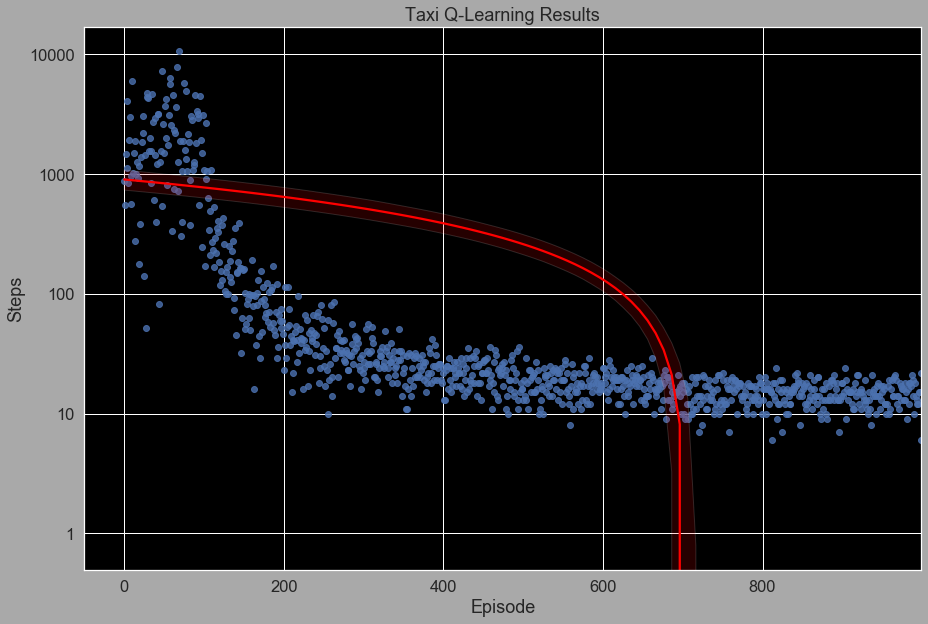

In [179]:
# Plot Q Learning Results
plotResults(taxiQLearningResults, "Taxi Q-Learning", True)

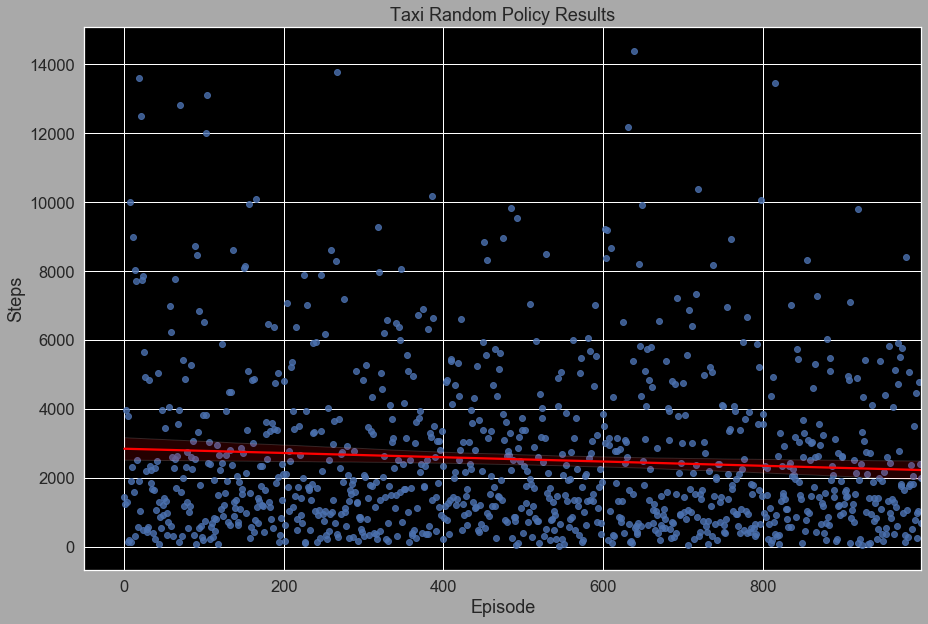

In [174]:
# Plot Random Policy Results
plotResults(taxiRandomResults, "Taxi Random Policy")

### 4.2. Graphing CartPole Results

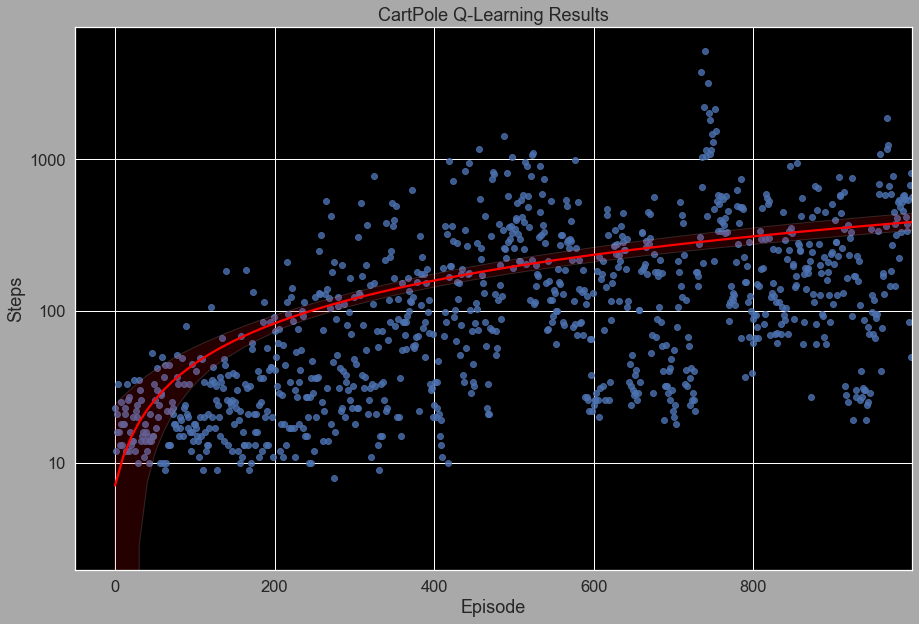

In [175]:
# Plot Q Learning Results
plotResults(cartQLearningResults, "CartPole Q-Learning", True)

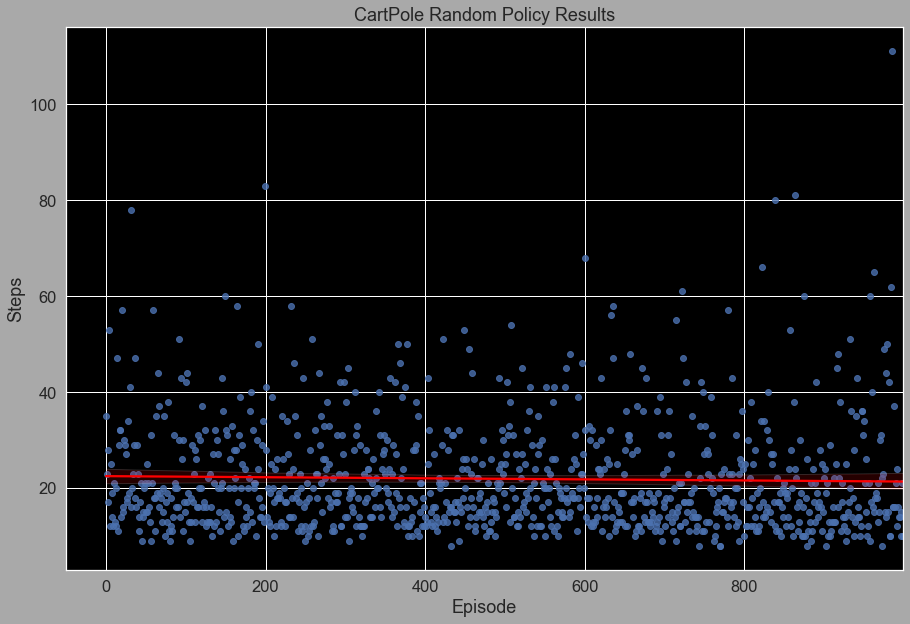

In [177]:
# Plot Random Policy Results
plotResults(cartRandomResults, "CartPole Random Policy")